### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../kaggle_prediction_library/') 
import preprocess
import feature_engineering
import submission
from sklearn.model_selection import train_test_split

# from hyperopt import tpe, fmin, Trials
# import hyperopt.hp as hp

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_validate, train_test_split

import matplotlib.pyplot as plt

import tqdm


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.neural_network import MLPClassifier


### Data set up

In [3]:
to_predict_mens = pd.read_csv("to_predict_mens.csv")

In [4]:
train = to_predict_mens[to_predict_mens.Season < 2017].copy()
test = to_predict_mens[to_predict_mens.Season >= 2017].copy()

features = [
    'seed_diff', 
            't1_adj_margin', 't2_adj_margin',
                't1_final_rank', 't2_final_rank',
                't1_OrdinalRank', 't2_OrdinalRank']

target = 'Outcome'

train[target] = train[target].astype(int)

train[features] = StandardScaler().fit_transform(train[features])



### Param Tuning

In [17]:
def get_best_params_from_grid_search(train, features, target, model, parameters, scoring, verbose=10):
    gs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scoring, verbose=verbose)
    gs.fit(train[features], train[target])
    return gs.best_params_


In [18]:
model = LogisticRegression(random_state=23)

parameters = {'C':[.00001, .0001, .001, .01, .1, 1, 100, 1000]}

best_params = get_best_params_from_grid_search(train, features, target, model, parameters, 
                                               scoring='neg_brier_score', verbose=0)

In [19]:
best_params

{'C': 0.01}

### Learning Curve

In [24]:
def plot_learning_curve(train, target, features, model, scoring, xlabel, ylabel, title, yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23):
    viz = LearningCurve(
        model, cv=cv, scoring=scoring, train_sizes=sizes, n_jobs=-1, random_state=random_state)
    viz.fit(train[features], train[target])
    viz.ax.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    if yticks:
        viz.ax.set_yticks(yticks)
    plt.show()

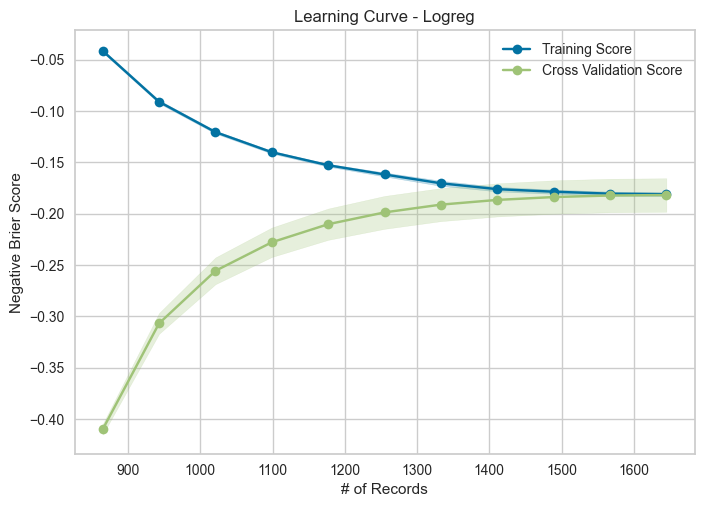

In [26]:
model = LogisticRegression(**best_params)

from yellowbrick.model_selection import ValidationCurve, LearningCurve
plot_learning_curve(train, 'Outcome', features, model, 
                    'neg_brier_score', 
                    "# of Records", 
                    "Negative Brier Score", 
                    "Learning Curve - Logreg", yticks=None, sizes=np.linspace(0.1, 1.0, 20), cv=StratifiedKFold(n_splits=10), random_state=23)


### CV Scoring

In [28]:
def rolling_season_cv(model, train_input, features, label='Outcome', cv_start=2007):
    ''' returns estimate for model performance using shifted validation'''
    
    scores = []

    for n, season in enumerate(train_input.Season.unique()):
        
        if season >= cv_start:

            train = train_input[train_input.Season < season]
            test = train_input[train_input.Season == season]

            X_train = train[features]
            X_test = test[features]
            y_train = train[label]
            y_test = test[label]

            model.fit(X_train[features], y_train)
            y_prob = model.predict_proba(X_test[features])
            loss = brier_score_loss(y_test, y_prob[:,1])
            scores.append((season, loss))

    validation_df = pd.DataFrame(scores, columns = ['season', 'score']).sort_values(by = 'score')
    avg_validation_score = validation_df.score.mean()
    return avg_validation_score


In [29]:
model = LogisticRegression(**best_params)
rolling_season_cv(model, train, features)

0.18223389278102672

In [7]:
df = pd.concat([train, test[test.type == 'Historical']], axis=0)

In [23]:
df.Season.unique()

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022])

In [38]:
scores = []
model = LogisticRegression(**best_params)

model = MLPClassifier(max_iter=1000, random_state=23, activation='tanh',
 alpha=0.0001, hidden_layer_sizes=(50,), learning_rate_init=0.005)

#for s in tqdm.tqdm([x + 2008 for x in range(10)]):

for s in tqdm.tqdm([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022]):

    prior_start = s - 5
    prior_end = s - 1

    post_start = s + 1
    post_end = s + 5

    tmp_train_prior = df[df.Season.isin(range(prior_start, prior_end+1))]
    #tmp_train_post = df[df.Season.isin(range(post_start, post_end+1))]
    #tmp_train_both = df[df.Season.isin(range(prior_start, post_end+1))]
    tmp_train_all = df[df.Season != s]
    tmp_train_all_prior = df[df.Season < s]

    tmp_test = df[df.Season == s]
    
    # prior
    model.fit(tmp_train_prior[features], tmp_train_prior['Outcome'])
    y_prob = model.predict_proba(tmp_test[features])
    loss = brier_score_loss(tmp_test['Outcome'], y_prob[:,1])
    scores.append((s, loss, 'prior'))

   #  # post
   #  model.fit(tmp_train_post[features], tmp_train_post['Outcome'])
   #  y_prob = model.predict_proba(tmp_test[features])
   #  loss = brier_score_loss(tmp_test['Outcome'], y_prob[:,1])
   #  scores.append((s, loss, 'post'))

   #  # both
   #  model.fit(tmp_train_both[features], tmp_train_both['Outcome'])
   #  y_prob = model.predict_proba(tmp_test[features])
   #  loss = brier_score_loss(tmp_test['Outcome'], y_prob[:,1])
   #  scores.append((s, loss, 'both'))

    # all 
    model.fit(tmp_train_all[features], tmp_train_all['Outcome'])
    y_prob = model.predict_proba(tmp_test[features])
    loss = brier_score_loss(tmp_test['Outcome'], y_prob[:,1])
    scores.append((s, loss, 'all'))

    # all_prior
    model.fit(tmp_train_all_prior[features], tmp_train_all_prior['Outcome'])
    y_prob = model.predict_proba(tmp_test[features])
    loss = brier_score_loss(tmp_test['Outcome'], y_prob[:,1])
    scores.append((s, loss, 'all_prior'))



 11%|█         | 2/18 [00:03<00:31,  1.96s/it]/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 17%|█▋        | 3/18 [00:07<00:39,  2.65s/it]/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/skylerdale/.virtualenvs/ml_course/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: Conv

In [39]:
analysis_df = pd.DataFrame(scores, columns = ['season', 'score', 'prior_post'])

In [26]:
# Logreg
analysis_df.groupby('prior_post').agg(np.median).reset_index().sort_values(by='score')

,prior_post,season,score
4,prior,2012.0,0.186546
1,all_prior,2012.0,0.187118
2,both,2012.0,0.189162
3,post,2012.0,0.195289
0,all,2012.0,0.217634


In [31]:
# Neural Net
analysis_df.groupby('prior_post').agg(np.median).reset_index().sort_values(by='score')

,prior_post,season,score
2,both,2012.0,0.168908
0,all,2012.0,0.183860
3,post,2012.0,0.197567
1,all_prior,2012.0,0.220516
4,prior,2012.0,0.220516


In [ ]:
# Interesting - we seem to do the best using just the prior 5 years, rather than all past years, or all years

In [37]:
# Logreg
analysis_df.pivot(index='season', columns='prior_post', values='score' )

prior_post,all,all_prior,prior
season,,,
2004,0.218156,0.195562,0.195562
2005,0.212421,0.181088,0.181088
2006,0.219094,0.193754,0.193754
2007,0.210501,0.154417,0.154417
2008,0.209451,0.164421,0.164421
2009,0.209851,0.165017,0.165403
2010,0.217634,0.183650,0.182319
2011,0.230403,0.218268,0.217883
2012,0.220932,0.187118,0.185372


In [40]:
# neural net
analysis_df.pivot(index='season', columns='prior_post', values='score' )

prior_post,all,all_prior,prior
season,,,
2004,0.182777,0.175616,0.175616
2005,0.170997,0.249177,0.249177
2006,0.191055,0.235677,0.235677
2007,0.150286,0.220516,0.220516
2008,0.157880,0.160577,0.160577
2009,0.165068,0.200522,0.174191
2010,0.194592,0.269564,0.197350
2011,0.226994,0.228493,0.230049
2012,0.190683,0.184671,0.183912


In [43]:
df.shape

(2496, 70)

In [ ]:
B, W, W, W, B, W, W, W, B, W, W, W, B, W, B, B, B, B

In [ ]:
# some evidence that the neural network does better with more data
    # the fact that it does better when it uses all seasons to train with
    # the fact that it does better in the last 5/6 seasons (when past data is more plentiful)